# Notebook to make the graphs

## Reading the CSV files with the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Direct / No self-correction

metrics_direct_no_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-18T22-05-45.csv")

# Step-by-step / No self-correction

metrics_step_no_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-16T12-26-17.csv")
    
# Direct / Self-correction

metrics_direct_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-19T17-10-43.csv")

# Step-by-step / Self-correction

metrics_step_corr = pd.read_csv("experiments/noRAG_SQL/metrics_gpt-4o_2025-05-21T22-28-09.csv")

In [2]:
# Adding gold_difficulty column for the graphs

df_test = pd.read_csv("datasets/txt2sql_alerce_test_v3_1.csv")
metrics_step_corr["gold_difficulty"] = ""
metrics_direct_corr["gold_difficulty"] = ""
metrics_step_no_corr["gold_difficulty"] = ""
metrics_direct_no_corr["gold_difficulty"] = ""

for req_id in df_test["req_id"].unique():
    mask = (metrics_step_corr["query_id"] == req_id) & (metrics_step_corr["query_run"] != 0)
    metrics_step_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_direct_corr["query_id"] == req_id) & (metrics_direct_corr["query_run"] != 0)
    metrics_direct_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_step_no_corr["query_id"] == req_id) & (metrics_step_no_corr["query_run"] != 0)
    metrics_step_no_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    
    mask = (metrics_direct_no_corr["query_id"] == req_id) & (metrics_direct_no_corr["query_run"] != 0)
    metrics_direct_no_corr.loc[mask, "gold_difficulty"] = df_test.loc[df_test.req_id == req_id, "difficulty"].item()
    #print(df_test.loc[df_test.req_id == req_id, "difficulty"].item())

## Obtaining execution metrics

### Manual metrics

In [7]:
# Function to obtain the metrics for each case
def metrics(df):
    """Function to obtain the Execution metrics for each dataframe

    Args:
        df (pandas. DataFrame): DataFrame with the unitary metrics

    Returns:
        dict: Dictionary with all the Execution metrics obtained
    """
    # Obtain ER and EP for rows and columns
    # ER
    ER_row = df["r_row"].mean().round(2)
    ER_col = df["r_col"].mean().round(2)
    # EP
    EP_row = df["p_row"].mean().round(2)
    EP_col = df["p_col"].mean().round(2)
    
    # Obtain the EF-Score
    EF_row = ((2 * ER_row * EP_row) / (EP_row + ER_row)).round(2)
    EF_col = ((2 * ER_col * EP_col) / (EP_col + ER_col)).round(2)
    
    # Build result dictionary
    result_dict = {
        "Row metrics": {
            "ER": ER_row,
            "EP": EP_row,
            "EF-Score": EF_row
        },
        "Column metrics": {
            "ER": ER_col,
            "EP": EP_col,
            "EF-Score": EF_col
        }
    }
    
    return result_dict

In [8]:
# Obtaining all the metrics for this config
print("-"*100)
print("Direct / No self - correction")
print(metrics(metrics_direct_no_corr))
print("-"*100)

print("Step-by-step / No self-correction")
print(metrics(metrics_step_no_corr))
print("-"*100)

print("Direct / Self-correction")
print(metrics(metrics_direct_corr))
print("-"*100)

print("Step-by-step / Self-correction")
print(metrics(metrics_step_corr))
print("-"*100)

----------------------------------------------------------------------------------------------------
Direct / No self - correction
{'Row metrics': {'ER': 1.68, 'EP': 0.69, 'EF-Score': 0.98}, 'Column metrics': {'ER': 0.77, 'EP': 0.76, 'EF-Score': 0.76}}
----------------------------------------------------------------------------------------------------
Step-by-step / No self-correction
{'Row metrics': {'ER': 1.06, 'EP': 0.68, 'EF-Score': 0.83}, 'Column metrics': {'ER': 0.77, 'EP': 0.76, 'EF-Score': 0.76}}
----------------------------------------------------------------------------------------------------
Direct / Self-correction
{'Row metrics': {'ER': 0.87, 'EP': 0.71, 'EF-Score': 0.78}, 'Column metrics': {'ER': 0.75, 'EP': 0.74, 'EF-Score': 0.74}}
----------------------------------------------------------------------------------------------------
Step-by-step / Self-correction
{'Row metrics': {'ER': 0.87, 'EP': 0.71, 'EF-Score': 0.78}, 'Column metrics': {'ER': 0.76, 'EP': 0.75, 'EF-Sco

### Automatic table creation

In [9]:
def generate_latex_table(direct_noself, step_noself, direct_self, step_self, caption, label):
    def metrics(df):
        ER_row = df["r_row"].mean().round(2)
        ER_col = df["r_col"].mean().round(2)
        EP_row = df["p_row"].mean().round(2)
        EP_col = df["p_col"].mean().round(2)
        EF_row = ((2 * ER_row * EP_row) / (EP_row + ER_row)).round(2)
        EF_col = ((2 * ER_col * EP_col) / (EP_col + ER_col)).round(2)
        return {
            "Row metrics": {"ER": ER_row, "EP": EP_row, "EF-Score": EF_row},
            "Column metrics": {"ER": ER_col, "EP": EP_col, "EF-Score": EF_col}
        }

    # Compute all 4 sets of metrics
    m_noself_direct = metrics(direct_noself)
    m_noself_step   = metrics(step_noself)
    m_self_direct   = metrics(direct_self)
    m_self_step     = metrics(step_self)

    # Start LaTeX code
    latex = r"""\begin{table}[ht]
\centering
\begin{tabular}{|c|c|*{6}{c|}}
\hline
\multicolumn{2}{|c|}{} & \multicolumn{3}{c|}{\textbf{Rows}} & \multicolumn{3}{c|}{\textbf{Columns}} \\
\cline{3-8}
\multicolumn{2}{|c|}{} & \textbf{ER} & \textbf{EP} & \textbf{EF} & \textbf{ER} & \textbf{EP} & \textbf{EF} \\
\hline
"""

    # Add rows
    def add_row_block(label, m_direct, m_step):
        nonlocal latex
        latex += f"\\multirow{{2}}{{*}}{{\\textbf{{{label}}}}} & \\textbf{{Direct}} & {m_direct['Row metrics']['ER']} & {m_direct['Row metrics']['EP']} & {m_direct['Row metrics']['EF-Score']} & {m_direct['Column metrics']['ER']} & {m_direct['Column metrics']['EP']} & {m_direct['Column metrics']['EF-Score']} \\\\\n"
        latex += "\\cline{2-8}\n"
        latex += f" & \\textbf{{Step-by-Step}} & {m_step['Row metrics']['ER']} & {m_step['Row metrics']['EP']} & {m_step['Row metrics']['EF-Score']} & {m_step['Column metrics']['ER']} & {m_step['Column metrics']['EP']} & {m_step['Column metrics']['EF-Score']} \\\\\n"
        latex += "\\hline\n"

    add_row_block("No self-correction", m_noself_direct, m_noself_step)
    add_row_block("Self-correction", m_self_direct, m_self_step)

    # Close table
    latex += f"""\\end{{tabular}}
\\caption{{{caption}}}
\\label{{{label}}}
\\end{{table}}"""

    return latex

In [10]:
# Assuming you have the 4 dataframes ready
latex_code = generate_latex_table(
    direct_noself=metrics_direct_no_corr,
    step_noself=metrics_step_no_corr,
    direct_self=metrics_direct_corr,
    step_self=metrics_step_corr,
    caption="Métricas para la configuración sin RAG y SQL.",
    label="tab:noRAG_SQL"
)

# Print or save to file
print(latex_code)

\begin{table}[ht]
\centering
\begin{tabular}{|c|c|*{6}{c|}}
\hline
\multicolumn{2}{|c|}{} & \multicolumn{3}{c|}{\textbf{Rows}} & \multicolumn{3}{c|}{\textbf{Columns}} \\
\cline{3-8}
\multicolumn{2}{|c|}{} & \textbf{ER} & \textbf{EP} & \textbf{EF} & \textbf{ER} & \textbf{EP} & \textbf{EF} \\
\hline
\multirow{2}{*}{\textbf{No self-correction}} & \textbf{Direct} & 1.68 & 0.69 & 0.98 & 0.77 & 0.76 & 0.76 \\
\cline{2-8}
 & \textbf{Step-by-Step} & 1.06 & 0.68 & 0.83 & 0.77 & 0.76 & 0.76 \\
\hline
\multirow{2}{*}{\textbf{Self-correction}} & \textbf{Direct} & 0.87 & 0.71 & 0.78 & 0.75 & 0.74 & 0.74 \\
\cline{2-8}
 & \textbf{Step-by-Step} & 0.87 & 0.71 & 0.78 & 0.76 & 0.75 & 0.75 \\
\hline
\end{tabular}
\caption{Métricas para la configuración sin RAG y SQL.}
\label{tab:noRAG_SQL}
\end{table}


## Making the graphs

### No self-correction

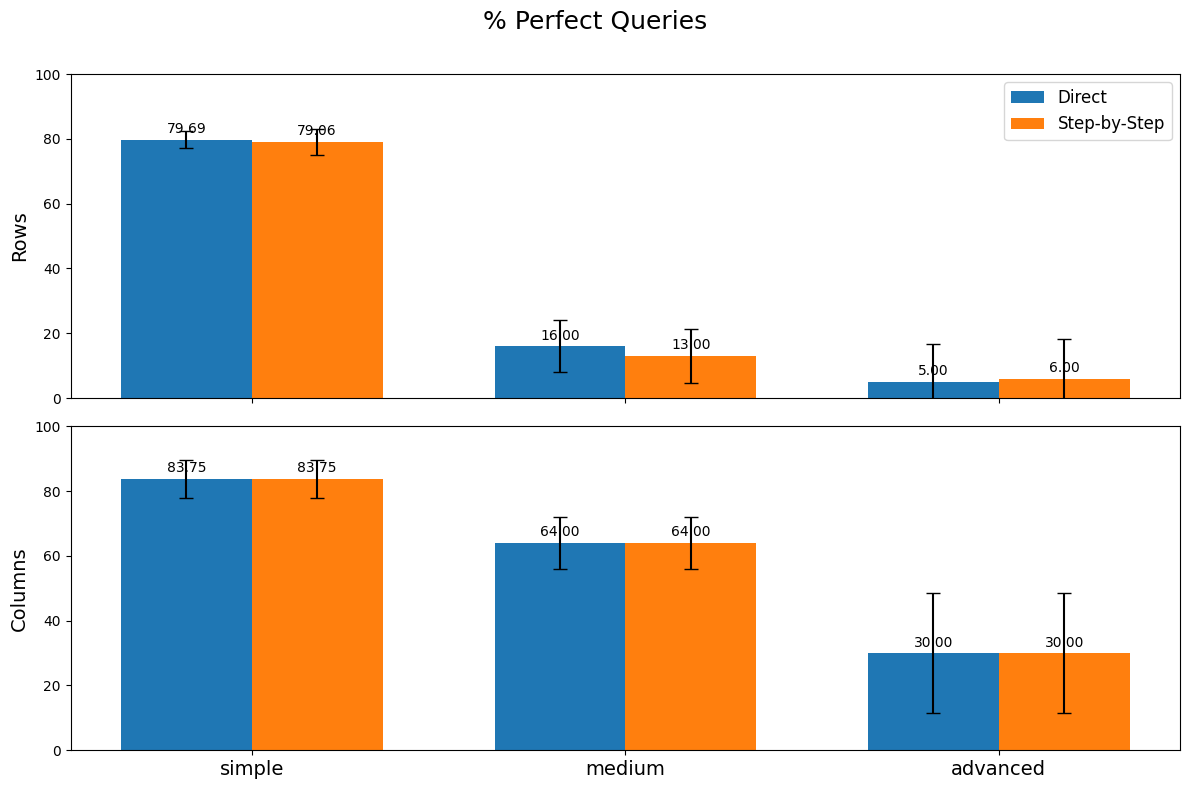

In [13]:
# Add prompt type before combining
metrics_direct_no_corr['prompt_type'] = 'Direct'
metrics_step_no_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_no_corr = metrics_direct_no_corr[metrics_direct_no_corr["query_run"] != 0]
metrics_step_no_corr = metrics_step_no_corr[metrics_step_no_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_no_corr, metrics_step_no_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:  # cambiar nombre label a difficulty
    for prompt in ['Direct', 'Step-by-Step']:
        # print(label, prompt)
        subset = df_all[(df_all['gold_difficulty'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_mean = subset['N_perfect_row'].mean()
        # row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        row_std = subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).mean()
        # display(subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).value_counts())
        
        # ---- Columns ----
        col_mean = subset['N_perfect_col'].mean()
        # col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()
        col_std = subset.groupby('query_id')['N_perfect_col'].apply(pd.Series.std).mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_mean * 100,
            'std_row': row_std * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_mean * 100,
            'std_col': col_std * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=18)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows", fontsize=14)
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns", fontsize=14)
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order, fontsize=14)

# Legend
axs[0].legend(loc="upper right", fontsize=12)

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()


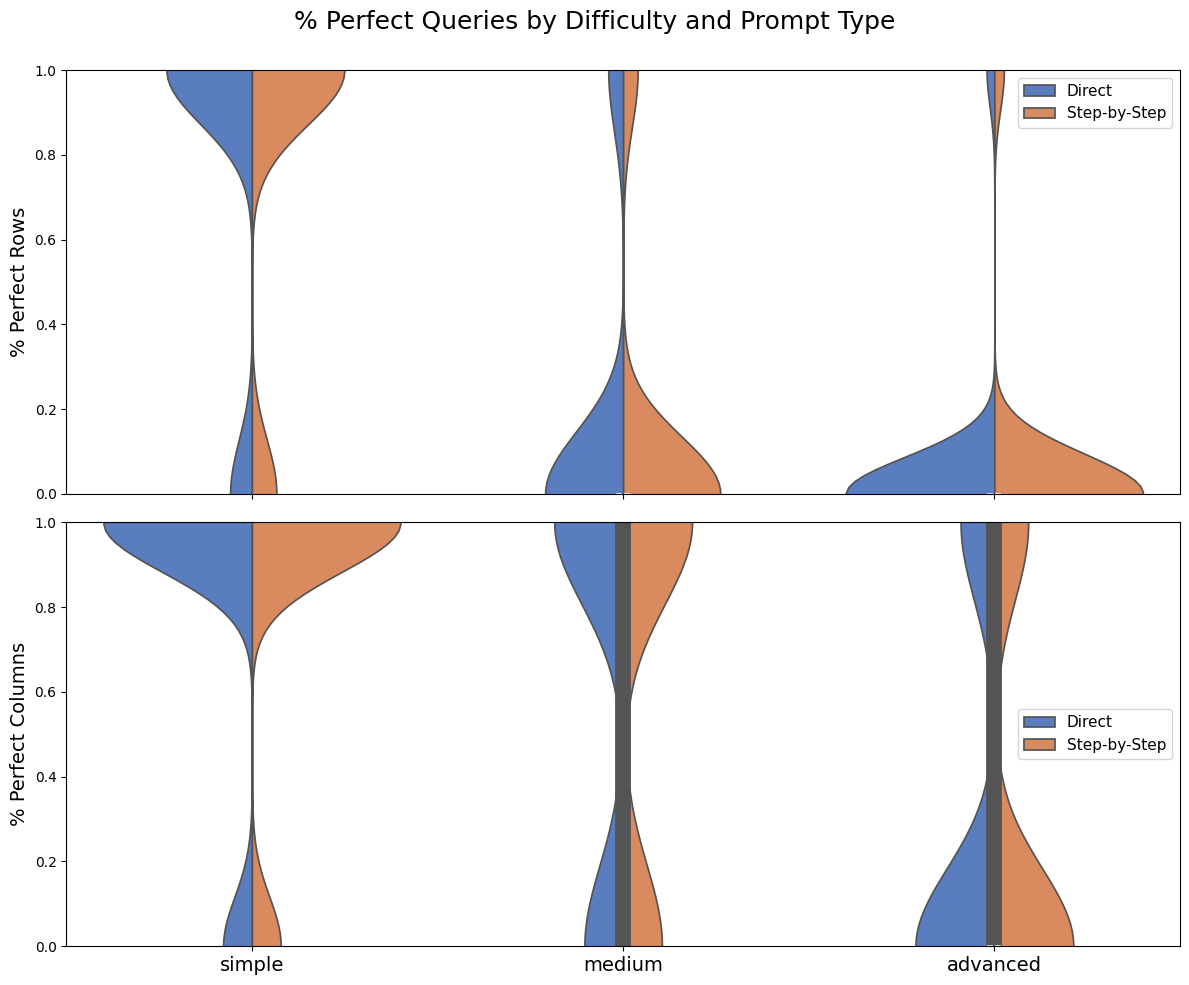

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('% Perfect Queries by Difficulty and Prompt Type', fontsize=18)

# ---- Violin Plot for Rows ----
sns.violinplot(
    data=df_all,
    x='gold_difficulty',
    y='N_perfect_row',
    hue='prompt_type',
    order=difficulty_order,
    palette='muted',
    split=True,
    ax=axs[0]
)
# axs[0].set_title('Rows', fontsize=16)
axs[0].set_ylabel('% Perfect Rows', fontsize=14)
axs[0].set_ylim(0, 1)  # since values are likely between 0 and 1
axs[0].legend(fontsize=11)

# ---- Violin Plot for Columns ----
sns.violinplot(
    data=df_all,
    x='gold_difficulty',
    y='N_perfect_col',
    hue='prompt_type',
    order=difficulty_order,
    palette='muted',
    split=True,
    ax=axs[1]
)
# axs[1].set_title('Columns', fontsize=16)
axs[1].set_ylabel('% Perfect Columns', fontsize=14)
#axs[1].set_xlabel('Difficulty', fontsize=14)
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelsize=14)
axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=11)

# Optional: Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


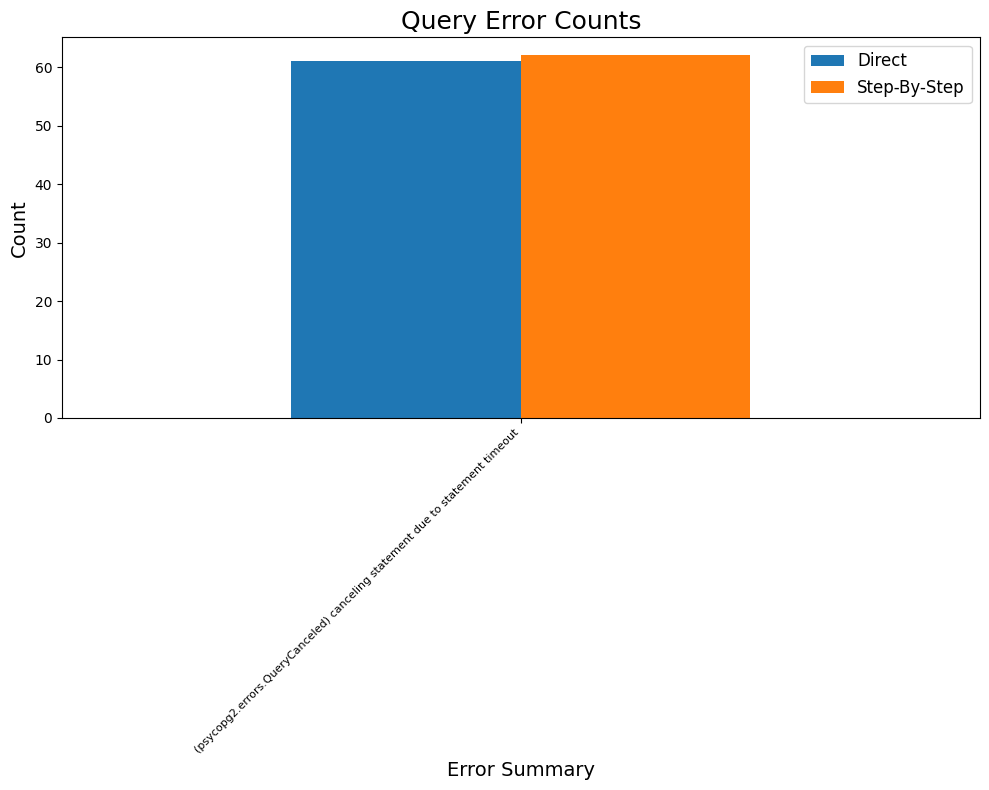

In [88]:
import pandas as pd
import matplotlib.pyplot as plt

# Preprocess the error labels
processed_dir = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Direct']["query_error"]
]

processed_step = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Step-by-Step']["query_error"]
]

# Count and filter
counts_dir = pd.Series(processed_dir).value_counts()
counts_step = pd.Series(processed_step).value_counts()

# Combine both counts into a DataFrame
df_counts = pd.DataFrame({
    'Direct': counts_dir,
    'Step-By-Step': counts_step
}).fillna(0)

# Filter only the rows with at least one count > 10
df_counts = df_counts[df_counts.max(axis=1) > 10]

# Plot grouped bar chart
ax = df_counts.plot(kind='bar', figsize=(10, 8))

plt.title('Query Error Counts', fontsize=18)
plt.xlabel('Error Summary', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(title='', fontsize=12)
plt.tight_layout()
plt.show()

### With self-correction

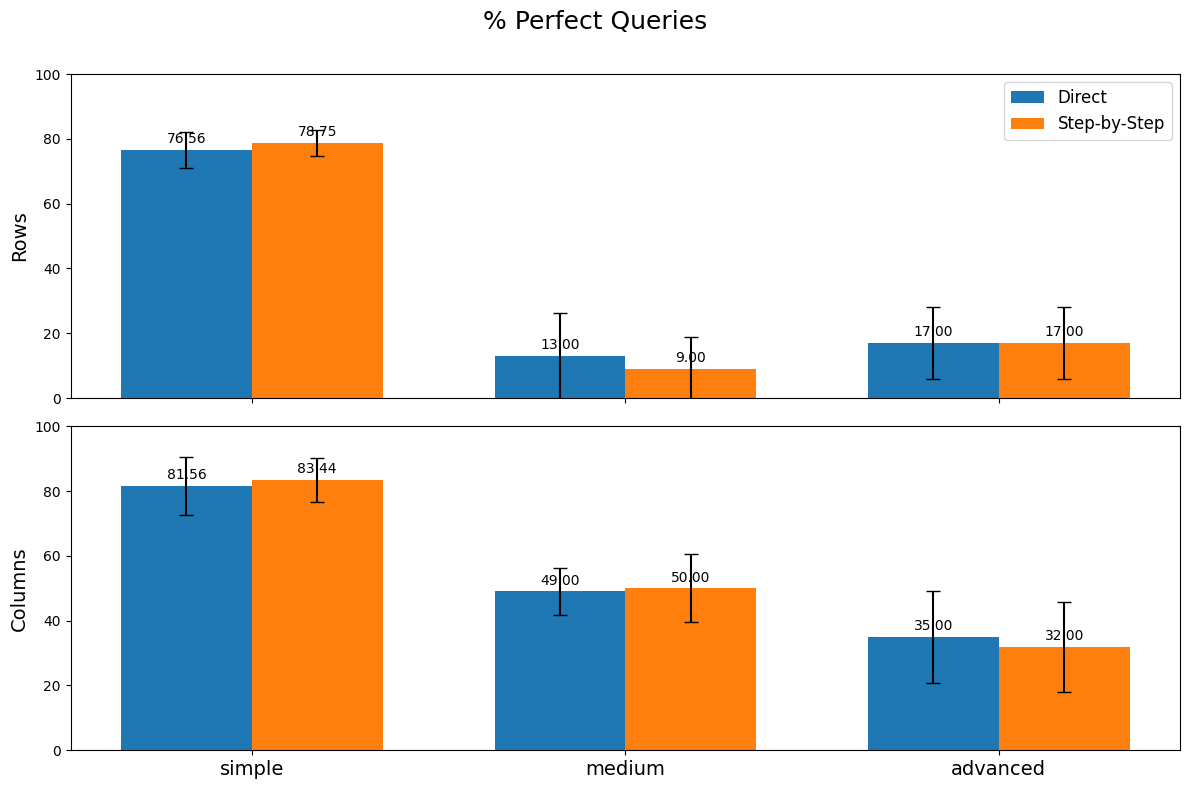

In [89]:
# Add prompt type before combining
metrics_direct_corr['prompt_type'] = 'Direct'
metrics_step_corr['prompt_type'] = 'Step-by-Step'

# Deleting the gold queries for this graphs
metrics_direct_corr = metrics_direct_corr[metrics_direct_corr["query_run"] != 0]
metrics_step_corr = metrics_step_corr[metrics_step_corr["query_run"] != 0]

# Combine the two
df_all = pd.concat([metrics_direct_corr, metrics_step_corr], ignore_index=True)

# Define and enforce difficulty ordering
difficulty_order = ['simple', 'medium', 'advanced']
df_all['label'] = pd.Categorical(df_all['label'], categories=difficulty_order, ordered=True)

# Group by label and prompt_type
summary_rows = []
summary_cols = []

for label in difficulty_order:
    for prompt in ['Direct', 'Step-by-Step']:
        # print(label, prompt)
        subset = df_all[(df_all['gold_difficulty'] == label) & (df_all['prompt_type'] == prompt)]
        
        # ---- Rows ----
        row_mean = subset['N_perfect_row'].mean()
        # row_stds = subset.groupby('query_id')['N_perfect_row'].std().sort_index().mean()
        row_std = subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).mean()
        # display(subset.groupby('query_id')['N_perfect_row'].apply(pd.Series.std).value_counts())
        
        # ---- Columns ----
        col_mean = subset['N_perfect_col'].mean()
        # col_stds = subset.groupby('query_id')['N_perfect_col'].std().sort_index().mean()
        col_std = subset.groupby('query_id')['N_perfect_col'].apply(pd.Series.std).mean()

        summary_rows.append({
            'label': label,
            'prompt_type': prompt,
            'mean_row': row_mean * 100,
            'std_row': row_std * 100
        })

        summary_cols.append({
            'label': label,
            'prompt_type': prompt,
            'mean_col': col_mean * 100,
            'std_col': col_std * 100
        })

# Convert to DataFrames
rows_df = pd.DataFrame(summary_rows)
cols_df = pd.DataFrame(summary_cols)

# Merge
summary = pd.merge(rows_df, cols_df, on=['label', 'prompt_type'])

# Sort values for consistent plotting
summary['label'] = pd.Categorical(summary['label'], categories=difficulty_order, ordered=True)
summary = summary.sort_values(['label', 'prompt_type'])

# Split by prompt type
direct = summary[summary['prompt_type'] == 'Direct']
step = summary[summary['prompt_type'] == 'Step-by-Step']

# Define bar plot parameters
x = np.arange(len(difficulty_order))  # x locations
width = 0.35

# Set up subplots
fig, axs = plt.subplots(2, 1, figsize=(12, 8), sharex=True)
fig.suptitle('% Perfect Queries', fontsize=18)

# ===== ROW PLOT =====
axs[0].bar(x - width/2, direct['mean_row'], width, yerr=direct['std_row'], capsize=5, label='Direct')
axs[0].bar(x + width/2, step['mean_row'], width, yerr=step['std_row'], capsize=5, label='Step-by-Step')
axs[0].set_ylabel("Rows", fontsize=14)
axs[0].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[0].text(x[i] - width/2, direct['mean_row'].values[i] + 2, f"{direct['mean_row'].values[i]:.2f}", ha='center')
    axs[0].text(x[i] + width/2, step['mean_row'].values[i] + 2, f"{step['mean_row'].values[i]:.2f}", ha='center')

# ===== COLUMN PLOT =====
axs[1].bar(x - width/2, direct['mean_col'], width, yerr=direct['std_col'], capsize=5, label='Direct')
axs[1].bar(x + width/2, step['mean_col'], width, yerr=step['std_col'], capsize=5, label='Step-by-Step')
axs[1].set_ylabel("Columns", fontsize=14)
axs[1].set_ylim(0, 100)

# Annotate bars
for i in range(len(x)):
    axs[1].text(x[i] - width/2, direct['mean_col'].values[i] + 2, f"{direct['mean_col'].values[i]:.2f}", ha='center')
    axs[1].text(x[i] + width/2, step['mean_col'].values[i] + 2, f"{step['mean_col'].values[i]:.2f}", ha='center')

# X-axis labels
axs[1].set_xticks(x)
axs[1].set_xticklabels(difficulty_order, fontsize=14)

# Legend
axs[0].legend(loc="upper right", fontsize=12)

# Tight layout
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
fig.suptitle('% Perfect Queries by Difficulty and Prompt Type', fontsize=18)

# ---- Violin Plot for Rows ----
sns.violinplot(
    data=df_all,
    x='gold_difficulty',
    y='N_perfect_row',
    hue='prompt_type',
    order=difficulty_order,
    palette='muted',
    split=True,
    ax=axs[0]
)
# axs[0].set_title('Rows', fontsize=16)
axs[0].set_ylabel('% Perfect Rows', fontsize=14)
axs[0].set_ylim(0, 1)  # since values are likely between 0 and 1
axs[0].legend(fontsize=11)

# ---- Violin Plot for Columns ----
sns.violinplot(
    data=df_all,
    x='gold_difficulty',
    y='N_perfect_col',
    hue='prompt_type',
    order=difficulty_order,
    palette='muted',
    split=True,
    ax=axs[1]
)
# axs[1].set_title('Columns', fontsize=16)
axs[1].set_ylabel('% Perfect Columns', fontsize=14)
#axs[1].set_xlabel('Difficulty', fontsize=14)
axs[1].set_xlabel('')
axs[1].tick_params(axis='x', labelsize=14)
axs[1].set_ylim(0, 1)
axs[1].legend(fontsize=11)

# Optional: Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)
plt.show()


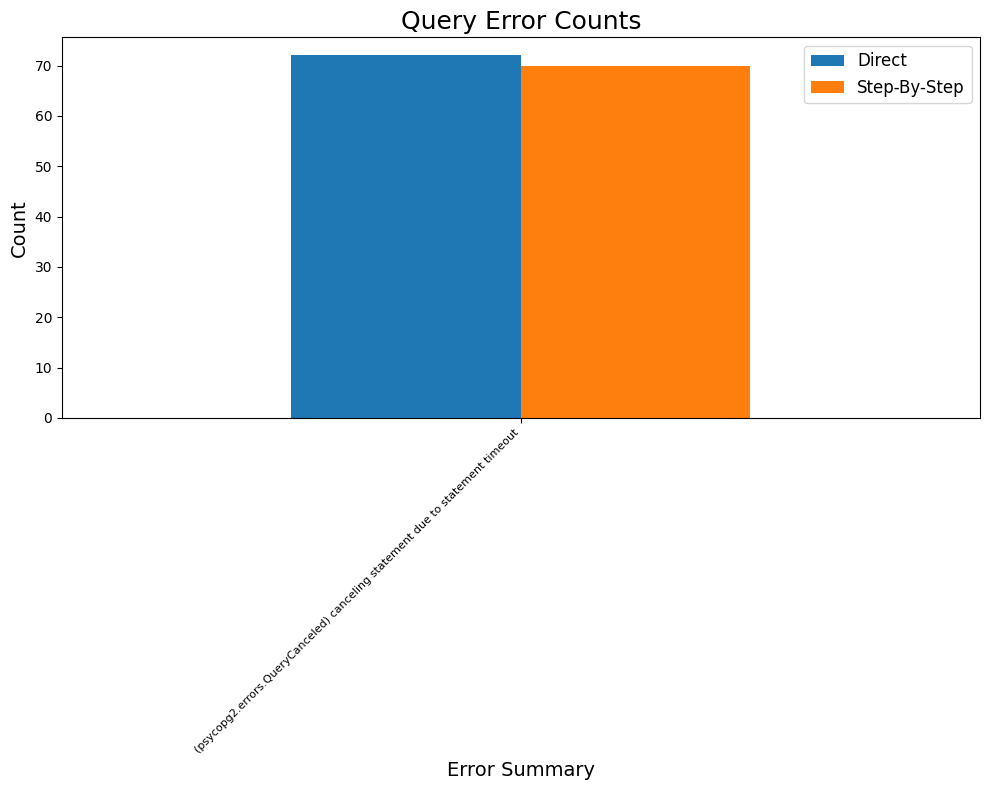

In [90]:
import pandas as pd
import matplotlib.pyplot as plt

# Preprocess the error labels
processed_dir = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Direct']["query_error"]
]

processed_step = [
    x.split("\n\n")[0] if isinstance(x, str) else None
    for x in df_all[df_all["prompt_type"] == 'Step-by-Step']["query_error"]
]

# Count and filter
counts_dir = pd.Series(processed_dir).value_counts()
counts_step = pd.Series(processed_step).value_counts()

# Combine both counts into a DataFrame
df_counts = pd.DataFrame({
    'Direct': counts_dir,
    'Step-By-Step': counts_step
}).fillna(0)

# Filter only the rows with at least one count > 10
df_counts = df_counts[df_counts.max(axis=1) > 10]

# Plot grouped bar chart
ax = df_counts.plot(kind='bar', figsize=(10, 8))

plt.title('Query Error Counts', fontsize=18)
plt.xlabel('Error Summary', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=8)
plt.legend(title='', fontsize=12)
plt.tight_layout()
plt.show()